<a href="https://colab.research.google.com/github/carloslme/handson-ml2-book/blob/main/06_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Introduction
*Decision Trees* are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting complex datasets. 

Decision Trees are also the fundamental components of Random Forests, which are among the most powerful Machine Learning algorithms available today.

# Training and Visualizing a Decision Tree
Let's build one Decision Tree and take a look at how it makes predictions.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

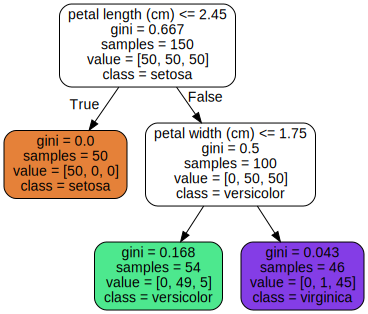

In [ ]:
from graphviz import Source
from sklearn.tree import export_graphviz
import os

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

# Making Predictions
You start at the *root node* (depth 0, at the top): this node asks whether the flower’s petal length is smaller than 2.45 cm. If it is, then you move down to the root’s left child node (depth 1, left). In this case, it is a *leaf node* (i.e., it does not have any child nodes), so it does not ask any questions: simply look at the predicted class for that node, and the Decision Tree predicts that your flower is an *Iris setosa* ( `class=setosa `).

Now suppose you find another flower, and this time the petal length is greater than 2.45 cm. You must move down to the root’s right child node (depth 1, right), which is not a leaf node, so the node asks another question: is the petal width smaller than 1.75 cm? If it is, then your flower is most likely an *Iris versicolor* (depth 2, left). If not, it is likely an *Iris virginica* (depth 2, right). It’s really that simple.

**Note**

One of the many qualities of Decision Trees is that they require very little data preparation. In fact, **they don’t require feature scaling or centering at all.** 

A node’s `samples` attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left). A node’s `value` attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 *Iris setosa* , 1 `Iris versicolor` , and 45 `Iris virginica `. Finally, a node’s gini attribute measures its *impurity* : a node is “pure” ( `gini=0` ) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to *Iris setosa* training instances, it is pure and its `gini` score is 0. Equation 6-1 shows how the training algorithm computes the `gini` score G i of the i th node. The depth-2 left node has a `gini` score equal to 1 – (0/54) 2 – (49/54) 2 – (5/54) 2 ≈ 0.168.

***Equation. Gini impurity***

$G(i) = 1 - ∑ (k=1, n) (p_{i,k})^2$

Where:

* $p_{i,k}$ is the radio of class $k$ instances among the training instances in the $i^{th}$ node.

**Note**

Scikit-Learn uses the CART algorithm, which produces only *binary trees*: nonleaf nodes always have two children (i.e., questions only have yes/no answers).
However, other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children.

Let's plot the Decision Tree's decision boundaries. 

Saving figure decision_tree_decision_boundaries_plot


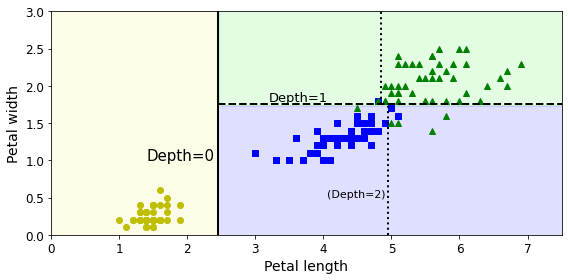

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

The thick vertical line represents the decision boundary of the root node (depth 0): petal length = 2.45 cm. Since the lefthand area is pure (only *Iris setosa*), it cannot be split any further. However, the righthand area is impure, so the depth-1 right node splits it at petal width = 1.75 cm (represented by the dashed line). Since `max_depth` was set to 2, the Decision Tree stops right there. If you set max_depth to 3, then the two depth-2 nodes would each add another decision boundary (represented by the dotted lines).

## Model Interpretation: White Box Versus Black Box
Decision Trees are intuitive, and their decisions are easy to interpret. Such models are often called *white box models*. In contrast, as we will see, Random Forests or neural networks are generally considered *black box models*. They make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made. For example, if a neural network says that a particular person appears on a picture, it is hard to know what contributed to this prediction: did the model recognize that person’s eyes? Their mouth? Their nose? Their shoes? Or even the couch that they were sitting on? Conversely, Decision Trees provide nice, simple classification rules that can even be applied manually if need be (e.g., for flower classification).

# Estimating Class Probabilities
A Decision Tree can also estimate the probability that an instance belongs to a particular class $k$. 
First it find the leaf node for the instance, and then it returns the ratio of training instances of class $k$ in this node and the highest probability.

In [ ]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [ ]:
tree_clf.predict([[5, 1.5]])

array([1])

# The CART Training Algorithm
Scikit-Learn uses the *Classification and Regression Tree* (CART) algorithm to train Decision Trees. The algorithm work by first splitting the trainin set into two subsets using a single feature $k$ and a threshold $t_{k}$ (e.g., “petal length ≤ 2.45 cm”).

It chooses $k$ and $t_{k}$ searching for the pair ($k$, $t_{k}$) that produces the purest subsets (weighted by their size). Next equation gives the cost function that the alrogithm tries to minimize.

***CART cost function for classification***

$J(k, t_{k}) = ∑(1,m) 1/2(y,y')^2$

Where:
* $∑$ is the sum over all samples
* $y$ true values
* $y'$ predicted values

Once the CART algorithm has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the max_depth hyperparameter), or if it cannot find a split that will reduce impurity.

A few other hyperparameters control additional stopping conditions ( `min_samples_split` , `min_samples_leaf` , `min_weight_fraction_leaf` , and `max_leaf_nodes` ).

**Warning**
CART algorithm is a greedy algorithm : it greedily searches for an optimum split at the top level, then repeats the process at each subsequent level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a solution that’s reasonably good but not guaranteed to be optimal.

Unfortunately, finding the optimal tree is known to be an NP-Complete problem: 2 it requires $O (exp( m ))$ time, making the problem intractable even for small training sets.

# Computational Complexity
Making predictions requires traversing the Decision Tree from the root to a leaf. Decision Trees generally are approximately balanced, so traversing the Decision Tree requires going through roughly O (log 2 ( m )) nodes. 3 Since each node only requires checking the value of one feature, the overall prediction complexity is O (log 2 ( m )), independent of the number of features. So predictions are very fast, even when dealing with large training sets.

The training algorithm compares all features (or less if max_features is set) on all samples at each node. Comparing all features on all samples at each node results in a training complexity of O ( n × m log 2 ( m )). For small training sets (less than a few thousand instances), Scikit-Learn can speed up training by presorting the data (set presort=True ), but doing that slows down training considerably for larger training sets.

# Gini Impurity or Entropy?
You can select the entropy impurity measure instead by setting the criterion hyperparameter to "`entropy`".

In Machine Learning, entropy is frequently used as an impurity measure: a set’s entropy is zero when it contains instances of only one class.

***Entropy***

$H i = - ∑ k = 1 p i , k ≠ 0 n p i , k log 2 ( p i , k)$


So, should you use Gini impurity or entropy? The truth is, most of the time it does not make a big difference: they lead to similar trees. 
* Gini impurity is slightly faster to compute, so it is a good default. 
* However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.


# Regularization Hyperparameters
Decision Trees make very few assumptions about the training data (as opposed to linear models, which assume that the data is linear, for example). It's needed to constrain the tree structure during training (this is called **regularization**), otherwise it will adapt itself to the training data, fitting it very closely (most likely overfitting it). 

Such a model is often called a nonparametric model , not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data.



The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the Decision Tree. Reducing the `max_depth` hyperparameter will in Scikit-Learn will regularize the model and this reduce the risk of overfitting. 

The `DecisionTreeClassifier` class has a few other parameters that similarly restrict the shape of the Decision Tree:

* `min_samples_split` (the minimum number of samples a node must have before it can be split)
* `min_samples_leaf` (the minimum number of samples a leaf node must have)
* `min_weight_fraction_leaf` (same as min_samples_leaf but expressed as a fraction of the total number of weighted instances)
* `max_leaf_nodes` (the maximum number of leaf nodes)
* and `max_features` (the maximum number of features that are evaluated for splitting at each node).

Increasing min_\* hyperparameters or reducing max_\* hyperparameters will regularize the model.

**Note** 

Other algorithms work by first training the Decision Tree without restrictions, then pruning (deleting) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically significant.



In [ ]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Saving figure min_samples_leaf_plot


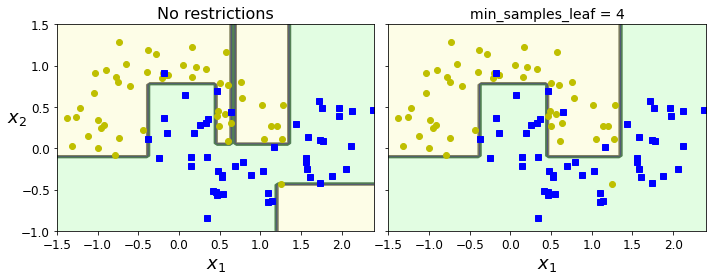

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

On the left the Decision Tree is trained with the default hyperparameters (i.e., no restrictions), and on the right it’s trained with min_samples_leaf=4 . It is quite obvious that **the model on the left is overfitting**, and the model on the right will probably generalize better.

# Regression
Decision Trees are also capable of performing regression tasks. With Scikit-Learn, let's use the `DecisionTreeRegressor` class, training it on a noisy wuadratic dataset with `max_depth=2`:

In [ ]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Saving figure tree_regression_plot


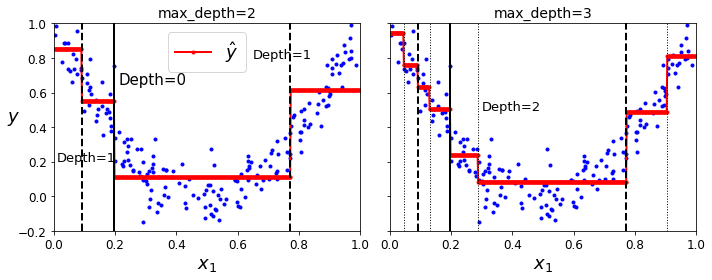

In [ ]:
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

Saving figure tree_regression_plot


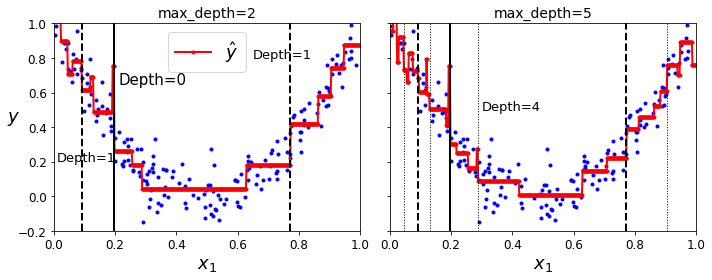

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=4)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=5)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=4", fontsize=13)
plt.title("max_depth=5", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

Here, the difference between a classifier tree and regression tree is that the last one predict a value instead of predicting a class.

**The predicted value for each region is always the average target value of the instances in the region** represented in the image above.


In [ ]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

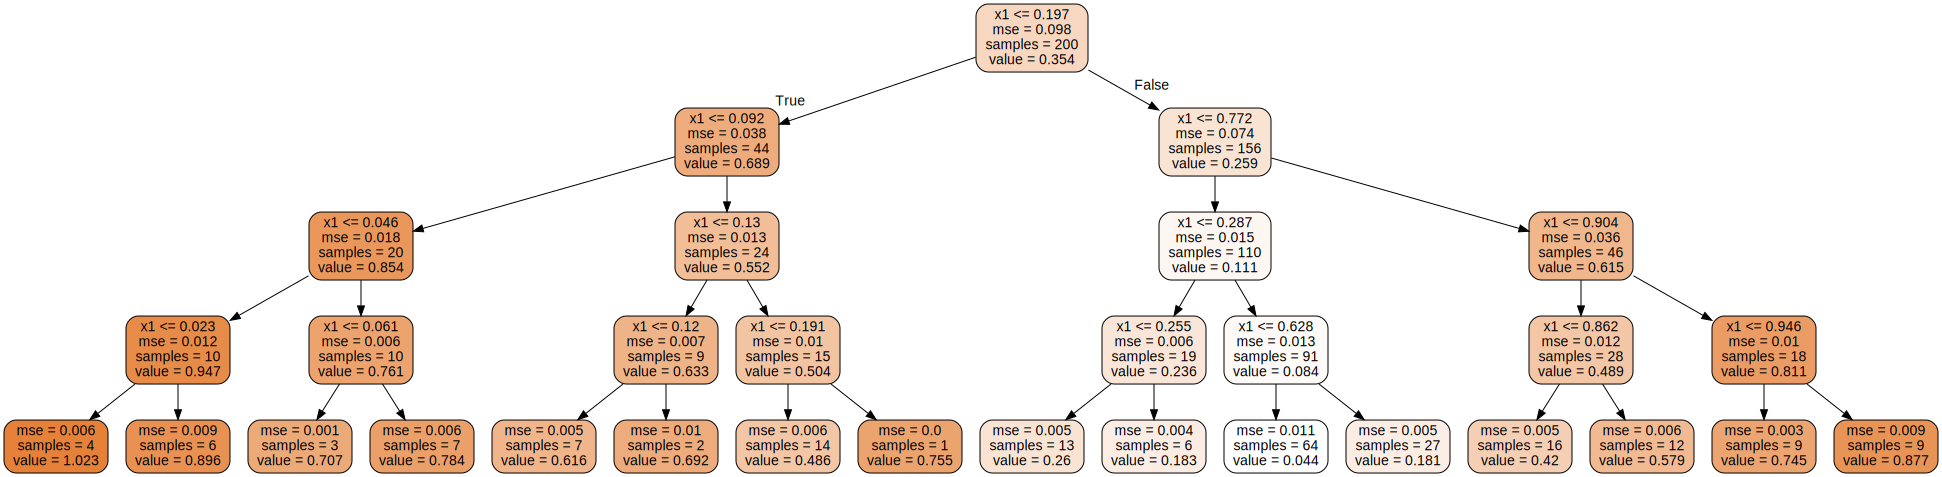

In [ ]:
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

The CART algorithm works mostly the same way as earlier, except that instead of trying to split the training set in a way that minimizes impurity, **it now tries to split the training set in a way that minimizes the MSE.**

***CART cost function for regression***




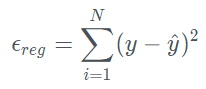

where $y$ are the predicted values from the model, and $\hat{y}$ are the observed values from the dataset. By summing over all $N$ observations of the differences between the model's predicted values and observed values, the total error of our model is calculated. The model is optimized to minimize the error value

**Without any regularization, the Decision Trees are prone to overfitting when dealing with regression tasks.**

For example, let's compare next to Decision Trees regressor. The first one does not have any regularization, and it is overfitting. Meanwhile, on the right, the regressor with just setting `min_sample_leaf=10` results in a much more reasonable model.

Saving figure tree_regression_regularization_plot


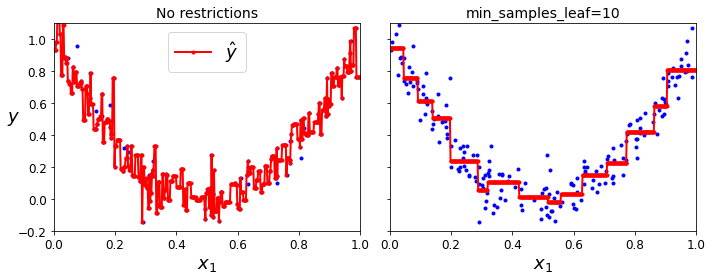

In [ ]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

# Instability
Although Decision Trees are simple to understand and interpret, easy to use, versatile, and powerful; they do have a few limitations:

* Decision Trees can split love orthogonal decision boundaries (all splits are perpendicular to an axis), 
* which makes them sensitive to training set rotation, as shown in the next figure. One way to limit this problem is to use Principal Component Analysis, which often results in a better orientation of the training data.

Saving figure sensitivity_to_rotation_plot


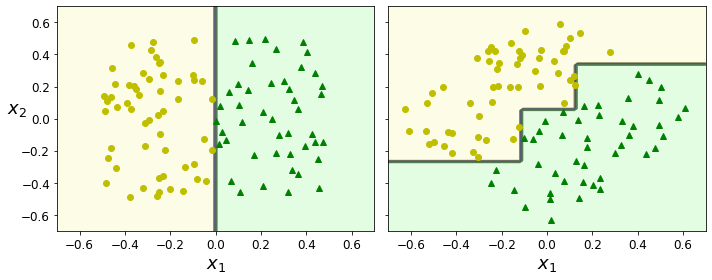

In [ ]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

* More generally, **the main issue with Decision Trees is that they are very sensitive to small variations in the training data**. You can get very different models even on the same training data, since the training algorithm used by Scikit-Learn is stochastic (it randomly selects the set of features to evaluate at each node). Unless you set the `random_state` hyperparameter.




In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris versicolor flower

array([[4.8, 1.8]])

In [ ]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=40, splitter='best')

Saving figure decision_tree_instability_plot


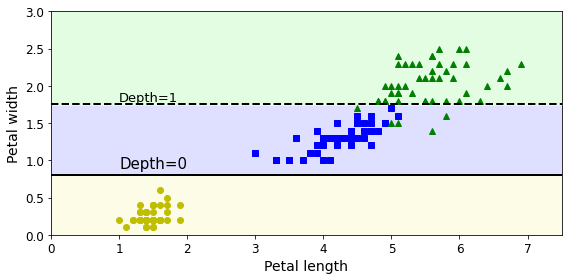

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

Random Forest can limit this instability by averaging predictions over many trees, as we will see in the next chapter.

# Exercises

## Exercise 1
**What is the appropiate depth of a Decision Tree trained (without restrictions) on a training set with one million instances?**

The depth of a well-balanced binary tree containing m leaves is equal to $log_{2} ( m )$, rounded up. A binary Decision Tree (one that makes only binary decisions, as is the case with all trees in Scikit-Learn) will end up more or less well balanced at the end of training, with one leaf per training instance if it is trained without restrictions. Thus, if the training set contains one million instances, the Decision Tree will have a depth of $log_{2} (10^6 ) ≈ 20$ (actually a bit more since the tree will generally not be perfectly well balanced).


## Exercise 2
**Is a node's Gini impurity generally lower or greater than it's parents? Is it generally lower/greater, or always lower/greater?**

A node’s Gini impurity is generally lower than its parent’s. This is due to the CART training algorithm’s cost function, which splits each node in a way that minimizes the weighted sum of its children’s Gini impurities. However, it is possible for a node to have a higher Gini impurity than its parent, as long as this increase is more than compensated for by a decrease in the other child’s impurity.



## Exercise 3
**If a Decision Tree is overfitting the training set, is it a good idea to try decreasing `max_depth`?**

Yes, since this will constrain the model, regularizing it.


## Exercise 4
**If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?**

Decision Trees don't care whether or not the training data is scaled or centered; that's one of the nice things about them. So if a Decision Tree underfits the training set, scaling the input features will just be a waste of time.

## Exercise 5
If it takes one hour to train a Decision Tree on a training set containing one million instances, roughly how much time will it take to train another Decisio Tree on a training set containing 10 million instances?

## Exercise 6
If your training set contains 100,000 instances, will setting `presort=True` speed up training?

## Exercise 7 
Train and fine-tune a Decision Tree for the moons datasets by following these steps:

* Use make_moons(n_samples=10000, noise=0.4) to generate a moons dataset.

* Use train_test_split() to split the dataset into a training set and a test set.

* Use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values for a DecisionTreeClassifier . Hint: try various values for max_leaf_nodes .

* Train it on the full training set using these hyperparameters, and measure your model’s performance on the test set. You should get roughly 85% to 87% accuracy.

## Exercise 8 
Grow a forest by following tese steps

* Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn’s ShuffleSplit class for this.

* Train one Decision Tree on each subset, using the best hyperparameter values found in the previous exercise. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy .

* Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy’s mode() function for this). This approach gives you majority-vote predictions over the test set.

* Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!